# Sturm Liouville decomposition gives some strange results

Looking at movies produced in the vs_compare notebook, we see that there appears to be an imprint of the first mode on the higher modes. To test I'll:

 - Make a Hovmöller of each mode along the centre of the beam. Check that angles match, suggesting that yes we do have multiple modes with the same phase speed
 - Check whether the stratification changes with time in the blank case. We average temporally, but in this case the stratification might not be stable as it's spinning up from the homogenous state

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:33743' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33743,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:42153,Total threads: 4
Dashboard: /proxy/41219/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:44061,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [59]:
trange = 50
to_process = {
    "full-40": {
        "data":tt.collect_data(
            exptname="full-40",
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50))
        },
    "full-20": {
        "data":tt.collect_data(
            exptname="full-20",
            rawdata = ["rho"],
            # lfiltered = "10000-lowpass"
        ).sel(yb = slice(-50,50))
        },
    # "ideal-20": {
    #     "data":tt.collect_data(
    #         exptname="ideal-20",
    #         rawdata = ["rho","u","v"],
    #         timerange = (1000 - trange,1000 + trange)
    #     ).sel(yb = slice(-50,50))
    # }
    }

loading rho...	done.
loading rho...	done.


In [66]:
from datetime import datetime

# Define the start and end dates
start_date = datetime(2010, 1, 1)
end_date = datetime(2012, 12, 1)

# Calculate the difference between the two dates
difference = end_date - start_date

# Convert the difference to hours
hours = difference.total_seconds() / 3600

print(f"The number of hours between 01-01-2010 and 01-12-2012 is: {hours} hours")

The number of hours between 01-01-2010 and 01-12-2012 is: 25560.0 hours


In [63]:
to_process["full-40"]["data"].time

<xarray.DataArray 'time' (time: 48840)> Size: 391kB
array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 4.8838e+04, 4.8839e+04,
       4.8840e+04])
Coordinates:
  * time     (time) float64 391kB 1.0 2.0 3.0 ... 4.884e+04 4.884e+04 4.884e+04
Attributes:
    _FillValue:     nan
    units:          hours since 2012-12-01 00:00:00
    long_name:      time
    axis:           T
    calendar_type:  JULIAN
    calendar:       julian

In [64]:
to_process["full-20"]["data"].time


<xarray.DataArray 'time' (time: 96120)> Size: 769kB
array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 9.6118e+04, 9.6119e+04,
       9.6120e+04])
Coordinates:
  * time     (time) float64 769kB 1.0 2.0 3.0 ... 9.612e+04 9.612e+04 9.612e+04
Attributes:
    _FillValue:     nan
    units:          hours since 2010-01-01 00:00:00
    long_name:      time
    axis:           T
    calendar_type:  JULIAN
    calendar:       julian

## Apply vmode function to smooth experiment to see what's going wrong

In [22]:
to_process["full-20"]["data"].xb

<xarray.DataArray 'xb' (xb: 376)> Size: 3kB
array([  -0.,    4.,    8., ..., 1492., 1496., 1500.])
Coordinates:
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
Attributes:
    _FillValue:  nan
    units:       km
    long_name:   Distance along beam from Tasmania towards Macquarie Ridge

In [58]:
data = to_process["smooth-20"]["data"].isel(xb = [0],yb = [20])

H = data.bathy.fillna(0)
if H.mean("xb").mean("yb") <= 0:
    H *= -1
N = tt.getN(data.rho).mean("time").load()

data = xr.merge([N.rename("N"),H.rename("H")])

N = data.N.isel(xb = 0,yb = 0).drop_vars(["xb","yb"])
H = data.H.isel(xb = 0,yb = 0).drop_vars(["xb","yb"]).values


# N is on the zl grid. First add surface and seafloor values.
N_trunc = N.sel(zl = slice(0,H))
N_extend = np.zeros(N_trunc.shape[0] + 2)
z_extend = np.zeros(N_extend.shape[0])
z_extend[1:len(z_extend) - 1] = N_trunc.zl.values
N_extend[1:len(z_extend) - 1] = N_trunc.values
N_extend[0] = N_extend[1]
N_extend[-1] = N_extend[-2]
z_extend[0] = 0
z_extend[-1] = H
N_extend = xr.DataArray(N_extend,dims = "zl",coords = {"zl":z_extend})
f,M2 = 1/(17 * 3600), (28.984104 / 360) / (3600)


N_extend.integrate("zl") == 0

<xarray.DataArray ()> Size: 1B
array(True)

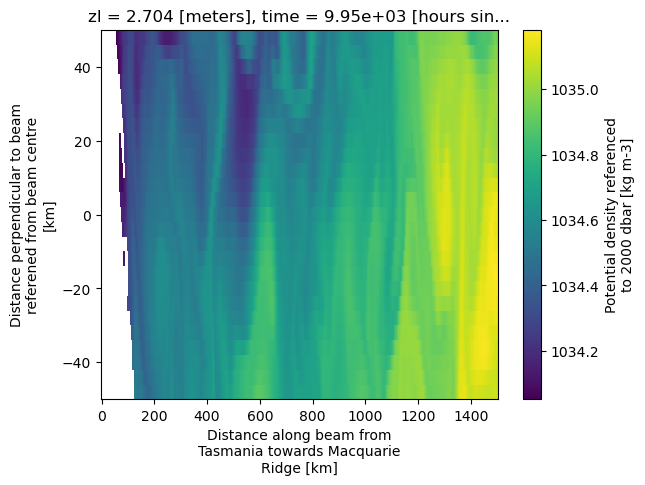

In [57]:
to_process["full-20"]["data"].isel(zl = 0,time = 0).rho.plot()

In [ ]:
to_process["smooth-20"]["data"].isel(xb = [0],yb = [20]).

In [20]:

# x = 40
# 0
# y = 

data = to_process["smooth-20"]["data"].isel(xb = [0],yb = [20])

H = data.bathy
if H.mean("xb").mean("yb") <= 0:
    H *= -1

N = tt.getN(data.rho).mean("time").load()

out = tt.ShootingVmodes(
    xr.merge([N.rename("N"),H.rename("H")])
)

ValueError: index must be monotonic increasing or decreasing

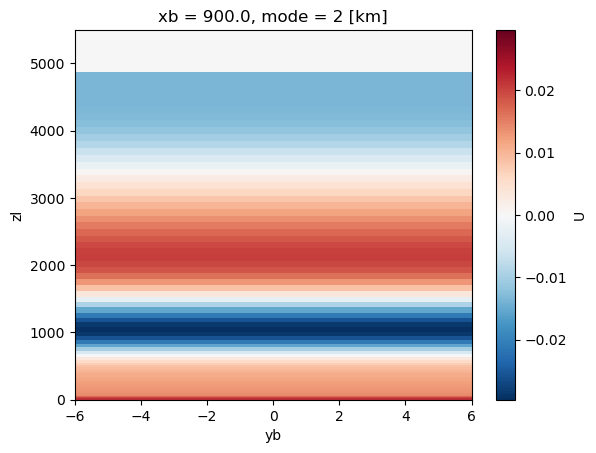

In [12]:
out.U.isel(mode = 2,xb = 0).plot()

Text(0.5, 1.0, '$ \\int\\int|u|dydt$')

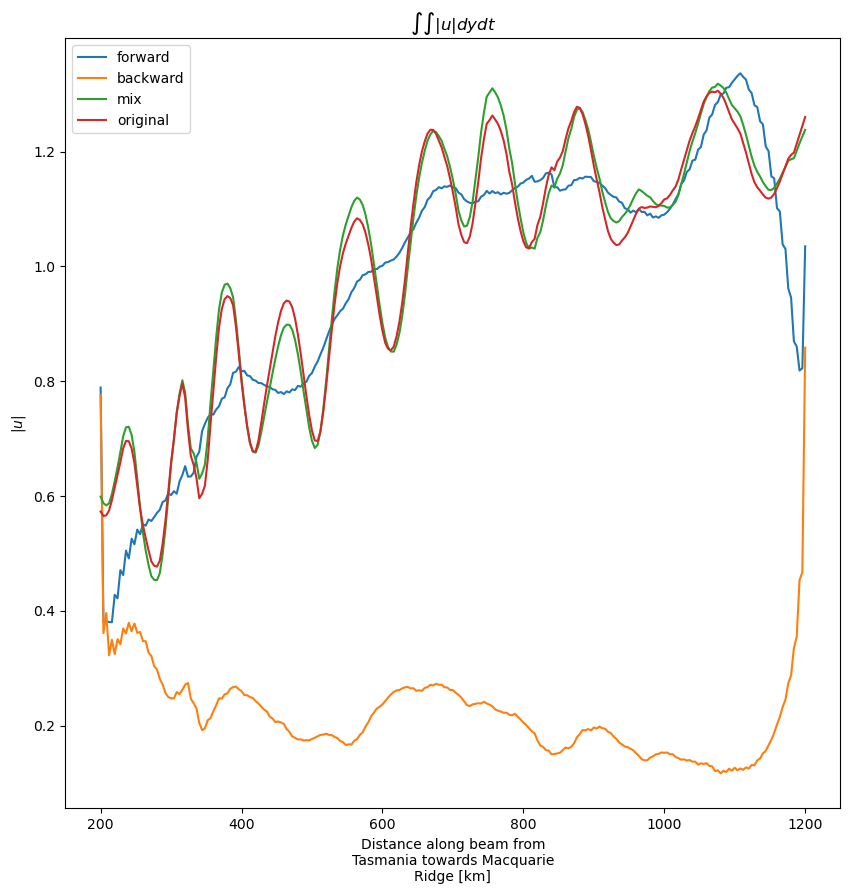

In [105]:
fig,ax = plt.subplots(1,figsize = (10,10))
np.abs(forward).mean("yb").mean("time").isel(mode = 0).plot(ax = ax,label = "forward")
np.abs(backward).mean("yb").mean("time").isel(mode = 0).plot(ax = ax,label = "backward")
np.abs(vmodesFull).u.mean("yb").sel(xb = slice(200,1200)).mean("time").isel(mode = 0).plot(ax = ax,label = "original")
# np.abs(ft).mean("yb").mean("time").isel(mode = 0).plot(ax = ax,label = "FT")

ax.legend()
ax.set_ylabel(r"$|u|$")
ax.set_title(r"$ \int\int|u|dydt$")
